### This file is for AFTER Google Colab updated on 2023-07-21
Important things to note:
1. Colab's Ubuntu upgraded from 20.04 LTS to 22.04 LTS
2. Colab's CUDA upgraded, and downgrading it was impossible due to Ubuntu's upgrade.

These changes required use of the latest MXNet package made for cuda 11.2, `mxnet-cu112`,
which worked on the newer version. Also, MXNet became officially archived.

In [ ]:
!cat /etc/*release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.2 LTS"
PRETTY_NAME="Ubuntu 22.04.2 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.2 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


# Importing other packages, and set context

In [ ]:
import numpy as np

import time
import math

In [ ]:
import pandas as pd

# Setting some data processing & NN properties variables used later

In [ ]:
# Some variables for data stuff later on
SEQ_LENGTH = 7
NUM_NEIGHBORS = 3

_DRIVE_ROOT_FLDR = 'drive/MyDrive/Colab Notebooks Project/'

STD_COLS = ['PM25', 'PM10', 'CO', 'NO2', 'O3_8', 'SO2']
y_feature = 'PM25'
x_features = list(set(STD_COLS) - {y_feature}) \
              + ['WS.max', 'WD.max']
print('sequence length:', SEQ_LENGTH)
print('number of neighbors:', NUM_NEIGHBORS)
print('y_feature:', y_feature)
print('x_features:', x_features)

TRAIN_CITIES_PERCENT = 0.25  # first 25% of the list (below) will be the training cities

# order randomized
citycodes_list = [
    131000,
    410100,
    370100,
    120000,
    130500,
    370800,
    130900,
    140400,
    130200,
    130600,
    410800,
    130400,
    140100,
    410600,
    140300,
    371700,
    410700,
    370300,
    371500,
    140500,
    410200,
    130100,
    131100,
    410500,
    371400,
    371600,
    410900,
    110000,
]
_cutoff = int( len(citycodes_list) * TRAIN_CITIES_PERCENT )
test_citycode_list = citycodes_list[:_cutoff]
train_citycode_list = citycodes_list[_cutoff:]
del _cutoff
print('number of total cities:', len(citycodes_list))
print(f'train cities ({len(train_citycode_list)}): ', train_citycode_list)
print(f'test cities ({len(test_citycode_list)}): ', test_citycode_list)

sequence length: 7
number of neighbors: 3
y_feature: PM25
x_features: ['SO2', 'NO2', 'PM10', 'CO', 'O3_8', 'WS.max', 'WD.max']
number of total cities: 28
train cities (21):  [140400, 130200, 130600, 410800, 130400, 140100, 410600, 140300, 371700, 410700, 370300, 371500, 140500, 410200, 130100, 131100, 410500, 371400, 371600, 410900, 110000]
test cities (7):  [131000, 410100, 370100, 120000, 130500, 370800, 130900]


# Google drive importing


In [ ]:
!ls

sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp 'drive/MyDrive/Colab Notebooks Project/jingjinji.csv' .
!cp 'drive/MyDrive/Colab Notebooks Project/aq_.csv' .

!cp -r 'drive/MyDrive/Colab Notebooks Project/params2' ./params2

In [ ]:
# testing saving to file
with open('test_out.txt', 'w') as f:
    f.write('hello world')
!cp 'test_out.txt' 'drive/MyDrive/Colab Notebooks Project/test_out.txt'

# test read from that saved file
!cp 'drive/MyDrive/Colab Notebooks Project/test_out.txt' .
with open('test_out.txt', 'r') as f:
    line_read = f.read()
    print(line_read)
    assert line_read.rstrip() == 'hello world'

hello world


# Data processing & sequencing methods


## left_join_the_dataframes

In [ ]:
def left_join_the_dataframes(jingjinji_filepath = 'jingjinji.csv',
                        airquality_filepath = 'aq_.csv'
                        ) -> tuple[pd.DataFrame, dict[int,str], dict[int,tuple[float,float]]]:
    '''
    Joins the two csv dataframes.
    Left-join air quality and jingjinji, on citycode & date, which adds data from jingjinji.
    Averages the values of the shared pollutant columns ['PM25', 'PM10', 'CO', 'NO2',
       'O3_8', 'SO2'].
    Ensures each row has the correct cityname (from the jingjinji dataset)
    and latitude longitude coordinates, as left joining leaves some of that out.

    Returns the joined dataframe, the mapping for citycodes to citynames,
    and the mapping for citycodes to (latitude,longitude) locations
    '''

    df_j = pd.read_csv(jingjinji_filepath)
    df_aq = pd.read_csv(airquality_filepath)

    ## prep columns for joining

    df_aq = df_aq.rename(columns={"O3_8h": "O3_8", "PM2.5": "PM25"}, errors='raise')
    df_aq['date'] = pd.to_datetime(df_aq['date'], errors='raise', dayfirst=False)
    df_j['date'] = pd.to_datetime(df_j['date'], errors='raise', dayfirst=False)

    ## join on citycode (and date)

    df = pd.merge(
        df_aq, df_j, how='left', on=['citycode', 'date'],
    )

    citycodes_names_dict = dict()
    citycodes_latlongs_dict = dict()

    for cc in set(df_j.citycode):
        # perform mask once
        ccmask = df_j.citycode.values == cc
        df_j_masked = df_j[ccmask]

        # get a set of any and all name(s)
        # corresponding to the citycode cc
        citycodes_names_dict[cc] = set(df_j_masked['cityname'].values)
        # do the same for the latitude, longitude
        citycodes_latlongs_dict[cc] = set(
                zip(
                    df_j_masked['latitude'].values,
                    df_j_masked['longitude'].values
                )
            )

    # make sure this dict only has one name per cc!
    assert all(len(cnset) == 1 for cc, cnset in citycodes_names_dict.items())
    # make sure this dict only has one lat,long pair per cc!
    assert all(len(llset) == 1 for cc, llset in citycodes_latlongs_dict.items())

    # convert the dict to directly mapping
    # each citycode to its unique cityname
    citycodes_names_dict = {cc: list(cnset)[0]
                            for cc, cnset in citycodes_names_dict.items()}
    # do the same for the latitude, longitude
    citycodes_latlongs_dict = {cc: list(llset)[0]
                            for cc, llset in citycodes_latlongs_dict.items()}

    # ensure every row each citycode has its city name
    # (the column 'cityname_y', from 'jingjinji.csv' df_j)
    # and its lat-long coordinates,
    # because left joining would not fill that in.
    for cc, cname in citycodes_names_dict.items():
        ccmask = df.citycode.values == cc
        clat, clong = citycodes_latlongs_dict[cc]
        df.loc[ccmask,'cityname_y'] = cname
        df.loc[ccmask,'latitude'] = clat
        df.loc[ccmask,'longitude'] = clong
    assert len(set(df.cityname_y)) == len(set(df.latitude)) == len(set(df.longitude))

    # print(df[df['WS.max'].isna()])  # expecting 1 row with NaN in that column; 2023-03-25 for citycode 140100

    df['PM25'] = df[['PM25_x', 'PM25_y']].mean(axis=1)
    df['PM10'] = df[['PM10_x', 'PM10_y']].mean(axis=1)
    df['CO'] =   df[['CO_x',   'CO_y']].mean(axis=1)
    df['NO2'] =  df[['NO2_x',  'NO2_y']].mean(axis=1)
    df['O3_8'] = df[['O3_8_x', 'O3_8_y']].mean(axis=1)
    df['SO2'] =  df[['SO2_x',  'SO2_y']].mean(axis=1)

    # print(df[df['WS.max'].isna()])  # expecting 1 row with NaN in that column; 2023-03-25 for citycode 140100

    # df = df.sort_values(by='date')
    df = df.sort_values(by=['citycode','date'])

    # print(df[df['WS.max'].isna()])  # expecting 1 row with NaN in that column; 2023-03-25 for citycode 140100
    # exit()

    return df, citycodes_names_dict, citycodes_latlongs_dict


## geo_azimuth_degrees (or bearing)

https://stackoverflow.com/a/1050914/14390381

it expects/assumes flat surface calculation

In [ ]:
from math import degrees, atan, pi

def geo_azimuth_degrees(lat1, long1, lat2, long2):
    '''
    The angle facing away from purely north is aka. the "azimuth" or "bearing".
    Measured clockwise from North (0 degrees --> 360 degrees).

    This function measures the bearing or azimuth
    from here (lat1,long1) pointing to there (lat2,long2).

    Returns result in degrees. (As multiplied from radians, by math.degrees)
    '''
    assert lat1 != lat2 or long1 != long2
    dlat = lat2 - lat1
    dlong = long2 - long1

    # https://stackoverflow.com/a/1050914/14390381
    # NOTE: reports it expects/assumes flat surface calculation
    # I also changed returns to degrees
    # and rearranged the order of operations such that
    # it shortcuts when dlong is == 0, avoiding division by 0
    if (dlong == 0):
        if (dlat < 0): return degrees(pi)
        return degrees(0)
    azimuth_radians = (pi * .5) - atan(dlat / dlong)
    if (dlong > 0): return degrees(azimuth_radians)
    elif (dlong < 0): return degrees(azimuth_radians + pi)


## geo_distance_haversine

In [ ]:
from math import cos, asin, sqrt

# Haversine distance, from Wikipedia, implemented by: https://stackoverflow.com/a/41337005/14390381
def geo_distance_haversine(lat1, long1, lat2, long2):
    p = 0.017453292519943295  # deg->radian conversion, pi/180
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((long2-long1)*p)) / 2
    return 12742 * asin(sqrt(hav))  # 12742 km diameter of Earth


## wind_dir_normalize

In [ ]:
def wind_dir_normalize(target_city_latlong, target_city_winddir,
                       neighbor_city_latlong, neighbor_city_winddir):
    '''
    Calc the neighbor's wind dir minus the relative bearing (ie. azimuth)
    pointing from neighbor towards target,
    and then linearly normalizes (maps)
    the diff's absolute value from [0,180] to [1,-1].

    In essence, this function returns a normalized result of "how far off" the
    neighbor's wind direction is from directly towards the target city.
    Note that
    IT DOES NOT FACTOR IN THE DISTANCE BETWEEN THE CITIES, NOR THE WIND SPEED.
    That is left for other code to perform.

    Note that a 90 deg. difference maps to 0; No difference maps to 1;
    180 deg. difference maps to -1.
    '''
    target_lat, target_long = target_city_latlong
    neighbor_lat, neighbor_long = neighbor_city_latlong

    # the angle between purely north and target_lat
    # aka. the "azimuth" or "bearing".
    # Measured clockwise from North (0 degrees --> 360 degrees)
    ngbr_to_trgt_bearing = geo_azimuth_degrees(neighbor_lat, neighbor_long,
                                               target_lat, target_long)

    diff = neighbor_city_winddir - ngbr_to_trgt_bearing

    # wraparound diff to [-180, 180]  if necessary
    #   where negative is ccw rotation and positive is cw rotation
    # example: target is at 90 deg bearing (E), and the ngbr wind dir is 315 deg (NW)
    #   NW is 135 degrees ccw from East; but diff would be (315-90)= 225 instead of -135
    #   (as 225 cw is equivalent to 135 ccw and -135 cw)
    if not (-180 <= diff <= 180):
        diff = ((diff + 180) % 360) - 180
    # print('  debug diff after:', diff)
    # assert -180 <= diff <= 180, f'wind dir diff {diff} outside of expected range [-180, 180]'

    normed = - (abs(diff) - 90) / 90
    return normed


## data_utils_df_normalizer functions

In [ ]:
!cp 'drive/MyDrive/Colab Notebooks Project/data_utils_df_normalizer.py' .
from data_utils_df_normalizer import standardize_dataframe_cols, normalize_wind_speed
from data_utils_df_normalizer import reverse_standardization, reverse_normalized_wind_speed

## are_consecutive_dates
`
are_consecutive_dates(dateslist, _debug: bool=True)
`

Where `dateslist` is an iterable listlike object


In [ ]:
def are_consecutive_dates(dateslist, _debug:bool=True):
    if _debug: print(dateslist)
    daydelta = np.timedelta64(1, 'D')
    datecheck = None
    for date in dateslist:
        if _debug: print('date', date)
        if datecheck is None:
            datecheck = date
        else:
            datecheck += daydelta
            _date_neq_datecheck = datecheck != date
            if _debug:
                print('datecheck:', datecheck, \
                    ' != ' if _date_neq_datecheck else ' == ', \
                    'date:', date)
            # check if it's daydelta away
            if _date_neq_datecheck:
                return False
    return True

## sequence

In [ ]:
def sequence(df: pd.DataFrame, y_feature: str, x_features: list[str], neighbor_features: list[str],
             cities_names_dict: dict[int,str], cities_latlongs_dict: dict[int,tuple[float,float]],
             seq_length, num_neighbors,
             wind_dir_colname: str, wind_speed_colname: str,
             separate_target_and_neighbor_X: bool,
             wind_dir_normalizing_function = wind_dir_normalize,
            #  single_wind_dir_normalizing_function = single_wind_dir_normalize,
             cities_df_filename_fmt: str = None,
             distance_colname = 'distance',
             ):
    '''
    Creates a dictionary of all the sequenced input tensors. Shaped like (num_of_sequences, seq_length, input_length)
    where input_length depends on the input tensor. the y tensor is (..., 1),
    while the x tensor(s) input_length vary depending on the length of x_features and neighbor_features.

    Wind directions are normalized according to param wind_dir_normalizing_function.

    Each neighbor city's features include an extra feature besides neighbor_features:
    the distance between it and the target city in each sequence.
    That distance is normalized by scaling it within [0, 1], according to the overall largest neighbor dist.
    That original maximum value is also returned.

    Returns:
    - (sequenced_data_tensors_dict, cities_neighbors, largest_neighbor_dist)

    where:
    - sequenced_data_tensors_dict is a dict with the citycodes as keys, and the values are dicts containing input tensors, keyed like:
        - key `'y'`: The y tensor. Shaped like `(num_sequences_for_city, seq_length, num_of_y_features)` and num_of_y_features is 1.
        - If separate_target_and_neighbor_X:
            - key `'targetx'`: The tensor for target X.
              Shaped like `(num_sequences_for_city, seq_length, num_of_x_features)`.
            - key `'neighborx'`: The tensor for target city's neighbors' Xs concatenated on the inputs axis.
              Shaped like `(num_sequences_for_city, seq_length, num_of_all_neighbors_features)`.
              Remember neighbor features include the distance feature as well.
              Therefore `num_of_all_neighbors_features == len(neighbor_features + 1) * seq_length.`
        - Otherwise:
            - key `'allx'`: The tensor for target and neighbor(s) Xs concatenated on the inputs axis.
              Shaped like `(num_sequences_for_city, seq_length, num_of_target_and_all_neighbors_features)`.
    - cities_neighbors is a dict keyed by citycode,
      with values of lists of tuples (neighbor_citycode, distance) sorted by the distance.
    - largest_neighbor_dist is the largest distance calculated between cities from DataFrame df,
      using cities_latlongs_dict for locations.
    '''

    # exclude entries from the city information dicts
    # which are not part of the df
    # so that the nearest neighbors processing will not count cities which aren't in df
    _df_citycodes = set(df['citycode'])
    assert _df_citycodes.issubset(cities_latlongs_dict)
    assert _df_citycodes.issubset(cities_names_dict)
    # print(len(cities_latlongs_dict))
    # print(len(cities_names_dict))
    cities_latlongs_dict = {cc: ccn for cc, ccn in cities_latlongs_dict.items() if cc in _df_citycodes}
    cities_names_dict = {cc: ccn for cc, ccn in cities_names_dict.items() if cc in _df_citycodes}
    # print(len(cities_latlongs_dict))
    # print(len(cities_names_dict))
    # exit()

    #####################################
    # JOIN NEIGHBORS


    # find nearest neighbors by distance and cache them

    cities_neighbors: dict[int, list[tuple[int, float]]] = {
        cc1:
            sorted((
                (cc2, geo_distance_haversine(lat1, long1, lat2, long2))
                for cc2, (lat2, long2) in cities_latlongs_dict.items()
                if cc1 != cc2
            ), key = lambda ccdist: ccdist[1])
            [0 : num_neighbors]  # get first num_neighbors items from sorted list
        for cc1, (lat1, long1) in cities_latlongs_dict.items()
    }

    largestneighbordist = max(
        ccdist
        for cc, neighborslist in cities_neighbors.items()
        for ccn, ccdist in neighborslist
    )

    print('largestneighbordist:', largestneighbordist)

    df_cc_grouped = df.groupby('citycode')
    df_cc_grouped_dict = {
        cc: df_group for cc, df_group in df_cc_grouped
    }


    # for each city cc, join its neighbors, and add their distances and fix their wind directions


    running_joined_df_dict: dict[int,pd.DataFrame] = dict()

    for cc, df_group in df_cc_grouped_dict.items():  # for each city and its grouped dataframe
        cc_name = cities_names_dict[cc]
        cc_neighbors = cities_neighbors[cc]
        print()
        print('cc:', cc, '| cc_name:', cc_name)

        if cities_df_filename_fmt is not None:
            df_group.to_csv(cities_df_filename_fmt.format(cc_name))

        # join (or merge) all of city cc's neighbors

        # 'running' because this will get
        # formatted neighbors merged onto it repeatedly later.
        # also, it contains the target city's data under the original columns.
        # df_running_joined = df_group[['date'] + neighbor_features]
        df_running_joined = df_group[['date','citycode'] + neighbor_features]


        dates_to_drop_from_df_running_joined = set()

        for i, (ccn, ccdist) in enumerate(cc_neighbors):  # for each neighbor city of this city
            _right_suffix = f'_n{i}'
            # print()
            print(f' | ind {i} len {len(cc_neighbors)}: | neighbor\'s cc (ccn) {ccn} | ccdist {ccdist}')

            neighbor_df = df_cc_grouped_dict[ccn][['date'] + neighbor_features]

            # normalize the distance of the neighbor
            with pd.option_context('mode.chained_assignment', None):
            # try:
                neighbor_df.loc[:, distance_colname + _right_suffix] = (ccdist / largestneighbordist)
                # just checking because there's a SettingWithCopyWarning being thrown
            # except pd.errors.SettingWithCopyWarning as swcw:
                # print('a'*1000)
                if not (neighbor_df[distance_colname + _right_suffix] == (ccdist / largestneighbordist)) \
                    .all():
                    print('setting failed')
                    # raise swcw
                    raise RuntimeError('Setting normalized distance failed to set')

            # edit and normalize the neighbor's wind directions,
            # potentially relative to this city cc's wind direction
            for ind in neighbor_df.index:

                # get the target city's winddir,
                #   by matching the date in df_running_joined
                _neighbor_df_date = neighbor_df.loc[ind,'date']
                _targetcity_matchingdate_mask = df_running_joined['date'].values == _neighbor_df_date
                _targetcity_matchingdate_1x1df = df_running_joined.loc[_targetcity_matchingdate_mask,
                    wind_dir_colname]
                if not len(_targetcity_matchingdate_1x1df.values) == 1:
                    # DEBUG
                    # IF THIS IS THE CASE, THEN THE CITYCODE & DATE DOESN'T EXIST IN df_running_joined
                    #   (That is probably because I DROPPED IT DUE TO IT BEING NaN!)
                    # print(_neighbor_df_date)
                    # print(df_running_joined[_targetcity_matchingdate_mask])
                    # print(_targetcity_matchingdate_1x1df)
                    # # So, SKIP IT
                    # print(f'intend to DROP date {_neighbor_df_date} for neighbor citycode {ccn}'
                    #       f' as row DOES NOT EXIST in target citycode {cc}')
                    # raise RuntimeError('DROP THE ROW FROM neighbor_df??')
                    dates_to_drop_from_df_running_joined.add(_neighbor_df_date)
                    print(f'SKIPPING normalizing wind dir for date {_neighbor_df_date} ccn {ccn} cc {cc} in target df running joined')
                    continue  # <-- SKIP FORMATTING THIS ROW

                assert len(_targetcity_matchingdate_1x1df.values) == 1
                target_city_winddir = _targetcity_matchingdate_1x1df.values[0]
                # check there's no invalid wind values
                if not (0 <= target_city_winddir <= 360):
                    # DEBUG
                    # If this happened, likely a NaN value was found for wind dir
                    print(_neighbor_df_date)
                    print(df_running_joined)
                    print(df_running_joined[_targetcity_matchingdate_mask])
                assert 0 <= target_city_winddir <= 360, 'is this assertion right or was it not 0<...<360? ' + str(target_city_winddir)

                # get the neighbor city's winddir
                neighbor_city_winddir = neighbor_df.loc[ind, wind_dir_colname]

                # calculate the normalized value using this (target) city's wind dir
                # and the neighbor city's wind dir, into the function
                neighbor_df.loc[ind, wind_dir_colname] = wind_dir_normalizing_function(
                        target_city_latlong = cities_latlongs_dict[cc],
                        target_city_winddir = target_city_winddir,
                        neighbor_city_latlong = cities_latlongs_dict[ccn],
                        neighbor_city_winddir = neighbor_city_winddir
                    )

            # end for

            # merge the neighbor into this city cc's running merge
            df_running_joined = pd.merge(
                df_running_joined,
                neighbor_df,
                on=['date'],
                how='left',
                suffixes=(None, _right_suffix)
            )

        # end for each neighbor city of this city

        print('dates to drop:', dates_to_drop_from_df_running_joined)


        # remove rows where data is NaN (such as the wind data, or rows only partially merged)
        _predropnalen = len(df_running_joined)
        df_running_joined = df_running_joined.dropna()
        _postdropnalen = len(df_running_joined)

        if _predropnalen != _postdropnalen:
            print(f'df_running_joined.dropna() removed {_predropnalen - _postdropnalen} rows')
        del _predropnalen
        del _postdropnalen


        # remove the ORIGINAL wind direction (now that we don't need it for reference)
        df_running_joined = df_running_joined.drop(columns=[wind_dir_colname])

        print('shape of df_running_joined:',
              '[' + ' x '.join(str(s)+n for s,n in zip(df_running_joined.shape,[' rows',' columns'])) + ']')
        print(df_running_joined.columns)
        # exit()

        running_joined_df_dict[cc] = df_running_joined

    # end for

    # each city cc in df_cc_grouped_dict now has
    # its neighbor features joined and put into running_joined_df_dict



    
    ###################################################
    # join all cities (before sequencing) to export as csv

    if False:  # only doing this for some debug purposes

        # export csv of all neighbors data before sequencing
        
        _before_sequencing_all_df = None
        for cc, df_running_joined in running_joined_df_dict.items():
            if _before_sequencing_all_df is None:
                _before_sequencing_all_df = df_running_joined
            else:
                assert set(_before_sequencing_all_df.columns) == set(df_running_joined.columns), \
                    'column lists of separate city dataframes do not match'
                # append the next dataframe df_running_joined for citycode cc
                _before_sequencing_all_df = _before_sequencing_all_df.append(df_running_joined)
        # export the final appended dataframe of all cities (before sequencing)
        _before_sequencing_csv_filename = f'processed_df_{num_neighbors}neighbors_before_sequencing.csv'
        _before_sequencing_all_df.to_csv(_before_sequencing_csv_filename)
        !cp {repr(_before_sequencing_csv_filename)} {repr('drive/MyDrive/Colab Notebooks Project/')}
        # print('Exiting early, before seqencing. Exported processed dataframe to CSV.')
        # return
        del _before_sequencing_all_df




    ###################################################
    # Now, convert that all to sequences

    cities_sequences_dict: dict[int,dict[str,np.ndarray]] = dict()

    # remove ORIGINAL WIND DIR as it's not needed,
    # and because we also dropped this from the tables earlier
    #  (so it no longer exists in them)
    assert wind_dir_colname in x_features, 'did x_features get modified??'
    x_features = [f for f in x_features if f != wind_dir_colname]

    assert wind_speed_colname in neighbor_features
    assert wind_dir_colname in neighbor_features

    all_neighbors_columns = [col+f'_n{i}'
                             for i in range(num_neighbors)
                             for col in (neighbor_features \
                                          + [# wind_speed_colname,
                                             # wind_dir_colname,
                                             distance_colname])
                             ]

    # vv  'PM25'
    print('y_feature:', y_feature)
    # vv  ['PM10', 'CO', 'SO2', 'O3_8', 'NO2', 'WS.max']
    print('(target?) x_features:', x_features)
    # vv  ['PM25_n0', 'PM10_n0', 'CO_n0', 'SO2_n0', 'O3_8_n0', 'NO2_n0', 'WS.max_n0', 'WD.max_n0', 'distance_n0', ... ]
    print('all_neighbors_columns:', all_neighbors_columns)


    _skipped = 0

    for cc, df_running_joined in running_joined_df_dict.items():

        # prepare some dicts to hold the sequences that are produced
        sequences_dict = dict()
        sequences_dict['y'] = list()
        if separate_target_and_neighbor_X:
            sequences_dict['targetx'] = list()
            sequences_dict['neighborx'] = list()
        else:
            sequences_dict['allx'] = list()

        row_ct = len(df_running_joined.index)

        # Extra -1 because of Y's pm25 being on the next day, after the Xs sequence.
        #    (So, for some dates t-(seq_length-1) to t, also need to capture the t+1 that is being predicted.)
        _indexes_to_start_on = list(df_running_joined.index)[:-(seq_length-1) - 1]
        for i in range(len(_indexes_to_start_on)):

            # Indexes of the rows for X

            # get a list of the consecutive indexes that will make up this sequence
            index_sublist = df_running_joined.index[i:i+seq_length]
            
            assert len(index_sublist) == seq_length, \
                    f'index_sublist: {index_sublist}' + \
                    f'  len(index_sublist): {len(index_sublist)}' + \
                    f'  seq_length: {seq_length}'

            # Index of the row for Y

            index_for_y = df_running_joined.index[i+seq_length]
            

            # check the dates are consecutive (all one day apart)
            if not are_consecutive_dates((
                        df_running_joined.loc[list(index_sublist) + [index_for_y], 'date']
                        ), _debug = False):
                print('NOT CONSECUTIVE; skipping this index sublist. ', index_sublist, ' Also with y index (',index_for_y,')')
                print(df_running_joined.loc[list(index_sublist) + [index_for_y], 'date'])
                _skipped += 1
                continue

            # WHAT SHAPE DO I NEED:
            # LSTM's NTC shape corresponds to (batch_size, seq_length, num_inputs)
            # so, I need to care about having (seq_length, num_inputs) shape
            #   because dataloader batches it.
            # ARRAY DATASET takes:
            # X and Y tensors as separate inputs
            #   so, make a big array of all the samples shaped (seq_length, num_inputs)

            # edit: Y actually needs to be (1) i.e. num_inputs Without the seq_length
            #   because Y is one data point, i.e. the following day's PM25.


            # Making a single sequence

            seq_TargetY = []
            seq_AllX = []
            seq_TargetX = []
            seq_NeighborXN = []

            # extract the X

            # for index in the sequence's indexes  ( which is the supposed t-(seq_length-1) to t )
            for index in index_sublist:

                if separate_target_and_neighbor_X:
                    # send target Xs and neighbor Xs separately (two input tensors)
                    target_X = df_running_joined.loc[index, x_features].values
                    neighbor_XN = df_running_joined.loc[index, all_neighbors_columns].values
                    seq_TargetX.append(target_X)
                    seq_NeighborXN.append(neighbor_XN)
                else:
                    # join all Xs together (target and neighbor X features both as one input tensor shape)
                    # ndarray list of values
                    all_X = df_running_joined.loc[index, x_features + all_neighbors_columns].values
                    seq_AllX.append(all_X)

            # extract the Y

            # ( which is the supposed t+1 )
            target_y = df_running_joined.loc[index_for_y, y_feature]
            target_y_as_list = [target_y] if type(y_feature) != list else target_y
            seq_TargetY.append(target_y_as_list)


            # save the sequence values into the dicts created earlier

            sequences_dict['y'].append(seq_TargetY)
            if separate_target_and_neighbor_X:
                sequences_dict['targetx'].append(seq_TargetX)
                sequences_dict['neighborx'].append(seq_NeighborXN)
            else:
                sequences_dict['allx'].append(seq_AllX)

        # end for i in range len _indexes_to_start_on   (going week by week)


        # convert all the sequences (the y and the Xs) in the dictionary
        #  to numpy arrays
        for _seqkey, _seq in sequences_dict.items():
            print(f'(citycode: {cc})')
            print('_seqkey:', _seqkey)
            _seq = np.array(_seq, copy=True)
            print('expecting samples shape to be like (seq_length, num_inputs)')
            print('_seq.shape:', _seq.shape)
            print('_seq.dtype:', _seq.dtype)
            print('first item (_seq[0]):')
            print(_seq[0])
            sequences_dict[_seqkey] = _seq

        cities_sequences_dict[cc] = sequences_dict
        print(list(df_running_joined.columns))

    # end for cc, df_running_joined in running_joined_df_dict.items()


    # now, cities_sequences_dict contains
    #  a dict of np.ndarrays
    #   which are the input tensors,
    #   shaped (num_seqs_for_cc, seq_length, num_inputs)
    #      where num_inputs is number of features that input tensor has


    print(all_neighbors_columns)

    print('total sequences _skipped (over all sequences processed):', _skipped)
    print('total created sequences (over all cities):', sum(cityseqdict['y'].shape[0] for cityseqdict in cities_sequences_dict.values()))
    for cc, cityseqdict in cities_sequences_dict.items():
        print(cc,
              '  y shape:  ', cityseqdict['y'].shape,
              *(tuple() if 'allx' not in cityseqdict else (';  allx shape:  ', cityseqdict['allx'].shape)),
              *(tuple() if 'targetx' not in cityseqdict else (';  targetx shape:  ', cityseqdict['targetx'].shape)),
              *(tuple() if 'neighborx' not in cityseqdict else (';  neighborx shape:  ', cityseqdict['neighborx'].shape)),
        )


    return cities_sequences_dict, cities_neighbors, largestneighbordist,

# Sequence the Data

In [ ]:
# distance between the same lat and long should be 0
assert 0.0 == geo_distance_haversine(120.565, -30.44, 120.565, -30.44)

df, cities_names_dict, cities_latlongs_dict = left_join_the_dataframes()

print('len of df.index (number of rows) before drop:', len(df.index))

# drop columns with nans in the WS.max and/or WD.max, because that will cause conversion problems
df = df.drop(index = df[df['WS.max'].isna() | df['WD.max'].isna()].index.values, inplace=False)

print('len of df.index (number of rows) after drop:', len(df.index))

# standardize and normalize the dataframe

df, means_stds_dict = standardize_dataframe_cols(df, STD_COLS)
df = df.rename(columns={"cityname_y": "cityname",
                "year_x": "year",
                "month_x": "month",
                "day_x": "day",
                },
                errors='raise')
df, windspeed_norm_min, windspeed_norm_max = normalize_wind_speed(df, 'WS.max')
print('columns:')
print(df.columns)

len of df.index (number of rows) before drop: 30687
len of df.index (number of rows) after drop: 30685
columns:
Index(['date', 'cityname_x', 'citycode', 'AQI', 'Chiefly_Infectant',
       'GradeDescription', 'SO2_x', 'NO2_x', 'PM10_x', 'CO_x', 'O3_8_x',
       'PM25_x', 'stationcode', 'year', 'month', 'day', 'PRE.2020', 'WS.ex',
       'WD.ex', 'P.mean', 'WS.mean.2min', 'T.mean', 'VP.mean', 'RHU.mean',
       'SSD', 'P.min', 'T.min', 'P.max', 'T.max', 'WS.max', 'WD.max',
       'RHU.min', 'provname', 'region', 'label', 'cityname', 'province',
       'SO2_y', 'NO2_y', 'PM10_y', 'CO_y', 'O3_8_y', 'PM25_y', 'station',
       '平均气压', '日照时数', '最高气温', '最小相对湿度', 'year_y', 'month_y', 'season',
       'longitude', 'latitude', 'day_y', 'PM25', 'PM10', 'CO', 'NO2', 'O3_8',
       'SO2'],
      dtype='object')


In [ ]:
# save the standardization info
print(means_stds_dict)
import json
with open('presequencing_means_stds_dict.json', 'w') as f:
  json.dump(means_stds_dict, f)
# copy out to the drive
!cp 'presequencing_means_stds_dict.json' 'drive/MyDrive/Colab Notebooks Project/presequencing_means_stds_dict.json'

{'PM25': (56.448841226897876, 42.8382211400005), 'PM10': (102.02195455878997, 60.13723953325887), 'CO': (1.0208978328173375, 0.5408125572025474), 'NO2': (39.23376242463745, 18.495761212656728), 'O3_8': (110.17880071696268, 57.34674467894985), 'SO2': (15.876600945087176, 11.644411888638128)}


## Do the SEPARATE target and neighbor Xs

In [ ]:
_dfcopy = df.copy()
seqs_dict, cities_neighbors, largestneighbordist = \
    sequence(_dfcopy, y_feature, x_features,
                  [y_feature]+x_features,  # neighbor features
                  cities_names_dict, cities_latlongs_dict,
                  seq_length = SEQ_LENGTH,  # 7,
                  num_neighbors = NUM_NEIGHBORS,  # 2,
                #   separate_target_and_neighbor_X = False,  # <----------
                  separate_target_and_neighbor_X = True,  # <----------
                  wind_dir_colname='WD.max',
                  wind_speed_colname='WS.max')

Streaming output truncated to the last 5000 lines.
dates to drop: {Timestamp('2019-09-15 00:00:00')}
df_running_joined.dropna() removed 1 rows
shape of df_running_joined: [1094 rows x 36 columns]
Index(['date', 'citycode', 'PM25', 'PM10', 'NO2', 'O3_8', 'CO', 'SO2',
       'WS.max', 'PM25_n0', 'PM10_n0', 'NO2_n0', 'O3_8_n0', 'CO_n0', 'SO2_n0',
       'WS.max_n0', 'WD.max_n0', 'distance_n0', 'PM25_n1', 'PM10_n1', 'NO2_n1',
       'O3_8_n1', 'CO_n1', 'SO2_n1', 'WS.max_n1', 'WD.max_n1', 'distance_n1',
       'PM25_n2', 'PM10_n2', 'NO2_n2', 'O3_8_n2', 'CO_n2', 'SO2_n2',
       'WS.max_n2', 'WD.max_n2', 'distance_n2'],
      dtype='object')

cc: 410200 | cc_name: 开封市
 | ind 0 len 3: | neighbor's cc (ccn) 410100 | ccdist 62.566239679451044
 | ind 1 len 3: | neighbor's cc (ccn) 410700 | ccdist 66.06231579869366
 | ind 2 len 3: | neighbor's cc (ccn) 410600 | ccdist 105.63776894198341
dates to drop: set()
df_running_joined.dropna() removed 2 rows
shape of df_running_joined: [1094 rows x 36 colu

In [ ]:
print(seqs_dict.keys())
print(len(seqs_dict))
print(cities_names_dict)
print(cities_latlongs_dict)

dict_keys([110000, 120000, 130100, 130200, 130400, 130500, 130600, 130900, 131000, 131100, 140100, 140300, 140400, 140500, 370100, 370300, 370800, 371400, 371500, 371600, 371700, 410100, 410200, 410500, 410600, 410700, 410800, 410900])
28
{140800: '运城市', 341000: '黄山市', 140300: '阳泉市', 370700: '潍坊市', 340500: '马鞍山市', 370200: '青岛市', 131100: '衡水市', 331300: '绍兴市', 130600: '保定市', 330800: '衢州市', 130100: '石家庄市', 411700: '驻马店市', 330300: '温州市', 411200: '三门峡市', 321100: '镇江市', 410700: '新乡市', 610900: '安康市', 320600: '南通市', 410200: '开封市', 341600: '亳州市', 610400: '咸阳市', 140900: '忻州市', 320100: '南京市', 371300: '临沂市', 341100: '滁州市', 610300: '宝鸡市', 140400: '长治市', 370800: '济宁市', 340600: '淮北市', 370300: '淄博市', 131200: '张家口市', 340100: '合肥市', 330900: '舟山市', 130200: '唐山市', 330400: '嘉兴市', 411300: '南阳市', 321200: '泰州市', 410800: '焦作市', 611000: '商洛市', 320700: '连云港市', 410300: '洛阳市', 120000: '天津市', 341700: '池州市', 610500: '渭南市', 141000: '临汾市', 320200: '无锡市', 371400: '德州市', 341200: '阜阳市', 140500: '晋城市', 370900: '泰安市', 3407

In [ ]:
# save the joined citycode's names and latitude/longitudes mappings for later use, such as when graphing
import pickle
with open('joined_cc_names_dict.pickle', 'wb') as f:
  pickle.dump(cities_names_dict, f)
with open('joined_cc_latlongs_dict.pickle', 'wb') as f:
  pickle.dump(cities_latlongs_dict, f)
!cp 'joined_cc_names_dict.pickle' 'drive/MyDrive/Colab Notebooks Project/joined_cc_names_dict.pickle'
!cp 'joined_cc_latlongs_dict.pickle' 'drive/MyDrive/Colab Notebooks Project/joined_cc_latlongs_dict.pickle'

### Join together the sequences from all the training cities, then all the test cities (separate sequence lists)

In [ ]:
# for each citycode cc in the training and testing citycode lists, concatenate their data together into one big training array

training_seqs_y = np.concatenate([seqs_dict[cc]['y'] for cc in train_citycode_list]).astype(np.float64)
training_seqs_targetx = np.concatenate([seqs_dict[cc]['targetx'] for cc in train_citycode_list]).astype(np.float64)
training_seqs_neighborx = np.concatenate([seqs_dict[cc]['neighborx'] for cc in train_citycode_list]).astype(np.float64)
print('shape of entire training_seqs_y:', training_seqs_y.shape)
print('shape of entire training_seqs_targetx:', training_seqs_targetx.shape)
print('shape of entire training_seqs_neighborx:', training_seqs_neighborx.shape)

testing_seqs_y = np.concatenate([seqs_dict[cc]['y'] for cc in test_citycode_list]).astype(np.float64)
testing_seqs_targetx = np.concatenate([seqs_dict[cc]['targetx'] for cc in test_citycode_list]).astype(np.float64)
testing_seqs_neighborx = np.concatenate([seqs_dict[cc]['neighborx'] for cc in test_citycode_list]).astype(np.float64)
print('shape of entire testing_seqs_y:', testing_seqs_y.shape)
print('shape of entire testing_seqs_targetx:', testing_seqs_targetx.shape)
print('shape of entire testing_seqs_neighborx:', testing_seqs_neighborx.shape)

shape of entire training_seqs_y: (22697, 1, 1)
shape of entire training_seqs_targetx: (22697, 7, 6)
shape of entire training_seqs_neighborx: (22697, 7, 27)
shape of entire testing_seqs_y: (7547, 1, 1)
shape of entire testing_seqs_targetx: (7547, 7, 6)
shape of entire testing_seqs_neighborx: (7547, 7, 27)


#### Save to files in prepared_seqs/

In [ ]:
# save the sequence data to files now.
# The sequence information is stored in the 'prepared_seqs' folder.

!cp -r 'drive/MyDrive/Colab Notebooks Project/prepared_seqs' .
fn = f'prepared_seqs/{{}}_seqs_{NUM_NEIGHBORS}nbrs_seqlen{SEQ_LENGTH}.npy'
for name, seqsarr in (
    ('separated_train_y', training_seqs_y),
    ('separated_train_targetx', training_seqs_targetx),
    ('separated_train_neighborx', training_seqs_neighborx),
    ('separated_test_y', testing_seqs_y),
    ('separated_test_targetx', testing_seqs_targetx),
    ('separated_test_neighborx', testing_seqs_neighborx),
):
    save_fn = fn.format(name)
    print(f'saving to {save_fn!r} ...')
    print(f'  dtype: {seqsarr.dtype} , shape: {seqsarr.shape}')
    np.save(save_fn, seqsarr)
del save_fn
del fn
import pickle
print('saving cities_neighbors_dict and largestneighbordist ...')
with open('prepared_seqs/separated_cities_neighbors_dict.pickle', 'wb') as f:
    pickle.dump(cities_neighbors, f)
with open('prepared_seqs/separated_largestneighbordist.pickle', 'wb') as f:
    pickle.dump(largestneighbordist, f)
print('copying back to drive...')
!cp -r 'prepared_seqs' 'drive/MyDrive/Colab Notebooks Project/'
print('saved to those files')

saving to 'prepared_seqs/separated_train_y_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (22697, 1, 1)
saving to 'prepared_seqs/separated_train_targetx_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (22697, 7, 6)
saving to 'prepared_seqs/separated_train_neighborx_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (22697, 7, 27)
saving to 'prepared_seqs/separated_test_y_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (7547, 1, 1)
saving to 'prepared_seqs/separated_test_targetx_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (7547, 7, 6)
saving to 'prepared_seqs/separated_test_neighborx_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (7547, 7, 27)
saving cities_neighbors_dict and largestneighbordist ...
copying back to drive...
saved to those files


## Do the same for TOGETHER target and neighbor X cities now

In [ ]:
_dfcopy = df.copy()
seqs_dict, cities_neighbors, largestneighbordist = \
    sequence(_dfcopy, y_feature, x_features,
                  [y_feature]+x_features,  # neighbor features
                  cities_names_dict, cities_latlongs_dict,
                  seq_length = SEQ_LENGTH,  # 7,
                  num_neighbors = NUM_NEIGHBORS,  # 2,
                  separate_target_and_neighbor_X = False,  # <----------
                  # separate_target_and_neighbor_X = True,  # <----------
                  wind_dir_colname='WD.max',
                  wind_speed_colname='WS.max')

Streaming output truncated to the last 5000 lines.
dates to drop: {Timestamp('2018-03-25 00:00:00')}
df_running_joined.dropna() removed 1 rows
shape of df_running_joined: [1094 rows x 36 columns]
Index(['date', 'citycode', 'PM25', 'PM10', 'NO2', 'O3_8', 'CO', 'SO2',
       'WS.max', 'PM25_n0', 'PM10_n0', 'NO2_n0', 'O3_8_n0', 'CO_n0', 'SO2_n0',
       'WS.max_n0', 'WD.max_n0', 'distance_n0', 'PM25_n1', 'PM10_n1', 'NO2_n1',
       'O3_8_n1', 'CO_n1', 'SO2_n1', 'WS.max_n1', 'WD.max_n1', 'distance_n1',
       'PM25_n2', 'PM10_n2', 'NO2_n2', 'O3_8_n2', 'CO_n2', 'SO2_n2',
       'WS.max_n2', 'WD.max_n2', 'distance_n2'],
      dtype='object')

cc: 140300 | cc_name: 阳泉市
 | ind 0 len 3: | neighbor's cc (ccn) 130100 | ccdist 84.47748844443822
 | ind 1 len 3: | neighbor's cc (ccn) 140100 | ccdist 90.57503484057673
 | ind 2 len 3: | neighbor's cc (ccn) 130500 | ccdist 119.58720669248123
dates to drop: set()
df_running_joined.dropna() removed 1 rows
shape of df_running_joined: [1095 rows x 36 colum

In [ ]:
print(seqs_dict.keys())
print(len(seqs_dict))
print(cities_names_dict)

dict_keys([110000, 120000, 130100, 130200, 130400, 130500, 130600, 130900, 131000, 131100, 140100, 140300, 140400, 140500, 370100, 370300, 370800, 371400, 371500, 371600, 371700, 410100, 410200, 410500, 410600, 410700, 410800, 410900])
28
{140800: '运城市', 341000: '黄山市', 140300: '阳泉市', 370700: '潍坊市', 340500: '马鞍山市', 370200: '青岛市', 131100: '衡水市', 331300: '绍兴市', 130600: '保定市', 330800: '衢州市', 130100: '石家庄市', 411700: '驻马店市', 330300: '温州市', 411200: '三门峡市', 321100: '镇江市', 410700: '新乡市', 610900: '安康市', 320600: '南通市', 410200: '开封市', 341600: '亳州市', 610400: '咸阳市', 140900: '忻州市', 320100: '南京市', 371300: '临沂市', 341100: '滁州市', 610300: '宝鸡市', 140400: '长治市', 370800: '济宁市', 340600: '淮北市', 370300: '淄博市', 131200: '张家口市', 340100: '合肥市', 330900: '舟山市', 130200: '唐山市', 330400: '嘉兴市', 411300: '南阳市', 321200: '泰州市', 410800: '焦作市', 611000: '商洛市', 320700: '连云港市', 410300: '洛阳市', 120000: '天津市', 341700: '池州市', 610500: '渭南市', 141000: '临汾市', 320200: '无锡市', 371400: '德州市', 341200: '阜阳市', 140500: '晋城市', 370900: '泰安市', 3407

### Join together the sequences from all the training cities, then all the test cities (separate sequence lists)

In [ ]:
training_seqs_y = np.concatenate([seqs_dict[cc]['y'] for cc in train_citycode_list]).astype(np.float64)
training_seqs_allx = np.concatenate([seqs_dict[cc]['allx'] for cc in train_citycode_list]).astype(np.float64)
print('shape of entire training_seqs_y:', training_seqs_y.shape)
print('shape of entire training_seqs_allx:', training_seqs_allx.shape)

testing_seqs_y = np.concatenate([seqs_dict[cc]['y'] for cc in test_citycode_list]).astype(np.float64)
testing_seqs_allx = np.concatenate([seqs_dict[cc]['allx'] for cc in test_citycode_list]).astype(np.float64)
print('shape of entire testing_seqs_y:', testing_seqs_y.shape)
print('shape of entire testing_seqs_allx:', testing_seqs_allx.shape)

shape of entire training_seqs_y: (22697, 1, 1)
shape of entire training_seqs_allx: (22697, 7, 33)
shape of entire testing_seqs_y: (7547, 1, 1)
shape of entire testing_seqs_allx: (7547, 7, 33)


#### Save to files in prepared_seqs/

In [ ]:
# save the sequenced data to files in 'prepared_seqs' folder
!cp -r 'drive/MyDrive/Colab Notebooks Project/prepared_seqs' .
fn = f'prepared_seqs/{{}}_seqs_{NUM_NEIGHBORS}nbrs_seqlen{SEQ_LENGTH}.npy'
for name, seqsarr in (
    ('together_train_y', training_seqs_y),
    ('together_train_allx', training_seqs_allx),
    ('together_test_y', testing_seqs_y),
    ('together_test_allx', testing_seqs_allx),
):
    save_fn = fn.format(name)
    print(f'saving to {save_fn!r} ...')
    print(f'  dtype: {seqsarr.dtype} , shape: {seqsarr.shape}')
    np.save(save_fn, seqsarr)
del save_fn
del fn
import pickle
print('saving cities_neighbors_dict and largestneighbordist ...')
with open('prepared_seqs/together_cities_neighbors_dict.pickle', 'wb') as f:
    pickle.dump(cities_neighbors, f)
with open('prepared_seqs/together_largestneighbordist.pickle', 'wb') as f:
    pickle.dump(largestneighbordist, f)
print('copying back to drive...')
!cp -r 'prepared_seqs' 'drive/MyDrive/Colab Notebooks Project/'
print('saved to those files')

saving to 'prepared_seqs/together_train_y_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (22697, 1, 1)
saving to 'prepared_seqs/together_train_allx_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (22697, 7, 33)
saving to 'prepared_seqs/together_test_y_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (7547, 1, 1)
saving to 'prepared_seqs/together_test_allx_seqs_3nbrs_seqlen7.npy' ...
  dtype: float64 , shape: (7547, 7, 33)
saving cities_neighbors_dict and largestneighbordist ...
copying back to drive...
saved to those files


# Plot test versus train cities on shapefile map

In [ ]:
!cp 'drive/MyDrive/Colab Notebooks Project/joined_cc_names_dict.pickle' 'joined_cc_names_dict.pickle'
!cp 'drive/MyDrive/Colab Notebooks Project/joined_cc_latlongs_dict.pickle' 'joined_cc_latlongs_dict.pickle'
import pickle
with open('joined_cc_names_dict.pickle', 'rb') as f:
  cities_names_dict = pickle.load(f)
with open('joined_cc_latlongs_dict.pickle', 'rb') as f:
  cities_latlongs_dict = pickle.load(f)
import numpy as np

In [ ]:
_dists = dict()
for cc1, cll1 in cities_latlongs_dict.items():
  for cc2, cll2 in cities_latlongs_dict.items():
    if cc1 == cc2: continue
    _dists['-'.join(sorted((str(cc1),str(cc2))))] = geo_distance_haversine(*cll1, *cll2)
print(_dists)
print(max(_dists.values()))
del _dists

{'140800-341000': 906.5384901006727, '140300-140800': 389.87876588453895, '140800-370700': 757.8941704317343, '140800-340500': 789.8972939864767, '140800-370200': 855.7030425046273, '131100-140800': 514.8560918761307, '140800-331300': 1054.72517231848, '130600-140800': 582.8595839609216, '140800-330800': 1000.2070853727503, '130100-140800': 458.8970190333099, '140800-411700': 356.8954817429581, '140800-330300': 1205.3077256887898, '140800-411200': 33.252424739457815, '140800-321100': 840.709842176348, '140800-410700': 267.1333914457101, '140800-610900': 318.06729657308665, '140800-320600': 976.7226838717352, '140800-410200': 301.97371801878893, '140800-341600': 456.81083847759334, '140800-610400': 224.00325700419407, '140800-140900': 407.1571848962556, '140800-320100': 793.348625530668, '140800-371300': 668.748838672535, '140800-341100': 740.974959803622, '140800-610300': 352.43627234502696, '140400-140800': 230.7182739194509, '140800-370800': 508.61280928706583, '140800-340600': 543.8

In [ ]:
# copy over the shapefile data needed to plot the region outlines
!cp -r 'drive/MyDrive/Colab Notebooks Project/stanford-bw669kf8724-shapefile/' .

    id_0  iso name_0  id_1    name_1 hasc_1  ccn_1 cca_1     type_1  \
0   49.0  CHN  China   1.0     Anhui  CN.AH    0.0  None      Sh?ng   
1   49.0  CHN  China   2.0   Beijing  CN.BJ    0.0  None  Zhíxiáshì   
9   49.0  CHN  China  10.0     Hebei  CN.HB    0.0  None      Sh?ng   
11  49.0  CHN  China  12.0     Henan  CN.HE    0.0  None      Sh?ng   
14  49.0  CHN  China  15.0   Jiangsu  CN.JS    0.0  None      Sh?ng   
21  49.0  CHN  China  22.0   Shaanxi  CN.SA    0.0  None      Sh?ng   
22  49.0  CHN  China  23.0  Shandong  CN.SD    0.0  None      Sh?ng   
24  49.0  CHN  China  25.0    Shanxi  CN.SX    0.0  None      Sh?ng   
26  49.0  CHN  China  27.0   Tianjin  CN.TJ    0.0  None  Zhíxiáshì   
30  49.0  CHN  China  31.0  Zhejiang  CN.ZJ    0.0  None      Sh?ng   

       engtype_1 nl_name_1 varname_1  \
0       Province     ??|??     ?nhu?   
1   Municipality     ??|??   B?ij?ng   
9       Province        ??     Héb?i   
11      Province        ??     Hénán   
14      Province  

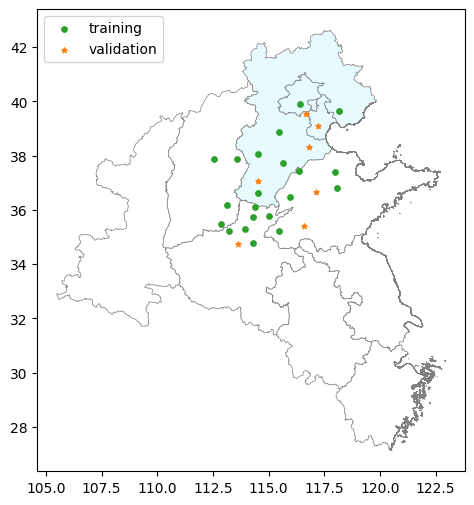

In [ ]:
# import geopandas for plotting the geographical data
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import numpy as np


N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 232/256, N)
vals[:, 1] = np.linspace(1, 252/256, N)
vals[:, 2] = np.linspace(1, 255/256, N)
newcmp = mcolors.ListedColormap(vals)
# [0,1] -> [white, very light blue]   used for coloring the jingjinji region(s)


# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

# fp = '.\\stanford-bw669kf8724-shapefile\\bw669kf8724.shp'
fp = 'stanford-bw669kf8724-shapefile/bw669kf8724.shp'

map_df: gpd.GeoDataFrame = gpd.read_file(fp)

# set the Jing-Jin-Ji region provinces to be colored in blue, using the 'jingjinji_mask' column for the ListedColormap. 0 will give it white and 1 will give it the bluish color, set above.

map_df['jingjinji'] = 0
jingjinji_mask = [i in (2.0, 10.0, 27.0) for i in map_df.id_1.values]
map_df.loc[jingjinji_mask, 'jingjinji'] = 1


mask = [(lambda i: i in [2.0, 10.0, 27.0  # Beijing Hebei Tianjin
                         , 23.0, 12.0, 1.0, 15.0, 31.0, 22.0, 25.0])(i) for i in map_df.id_1.values]  # Shandong Henan Anhui Jiangsu Zhejiang Shaanxi Shanxi
print(map_df[mask])
map_df = map_df[mask]


# plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams["figure.figsize"] = [16 * 2/3, 9 * 2/3]  # slightly smaller but same aspect ratio, for text sizing

# preview
# dfplt = map_df.plot(edgecolor=u'gray', linewidth=0.5, ax=axes1, column='jingjinji', cmap='Blues')
# dfplt = map_df.plot(edgecolor=u'gray', linewidth=0.5, ax=axes1, column='jingjinji', cmap=newcmp)
dfplt = map_df.plot(edgecolor=u'gray', linewidth=0.5, ax=plt.gca(), column='jingjinji', cmap=newcmp)


df3ll = {
    cc: cities_latlongs_dict[cc]
    for cc in set(train_citycode_list)
}
print(df3ll)
df4ll = {
    cc: cities_latlongs_dict[cc]
    for cc in set(test_citycode_list)
}
print(df4ll)


_swp_args = lambda a1, a2: (a2, a1)
# dfplt.scatter(*_swp_args(*zip(*dfll.values())), c='tab:orange', s=10, label='jingjinji.csv')
# dfplt.scatter(*_swp_args(*zip(*df2ll.values())), c='tab:green', s=10, label='aq_....csv')
dfplt.scatter(*_swp_args(*zip(*df3ll.values())), c='tab:green', s=15, label='training')#label='train_cities')
dfplt.scatter(*_swp_args(*zip(*df4ll.values())), marker='*', c='tab:orange', s=15, label='validation')#label='test_cities')

# dfplt.legend()
dfplt.legend(loc = 'upper left')
